In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Raw CSV/"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Mounted at /content/drive


In [2]:
summary_df = pd.DataFrame({
    'dataset': [],
    'filename': [],
    'var_name': [],
    'data_type': [],
    'num_null_values': [],
    'num_non_null_values': [],
    'num_duplicates_values': [],
    'num_unique_values': [],
    'mean': [],
    'median': [],
    'standard_deviation': []
})

for dataset in dataset_names:
  for root, dirs, files in os.walk(os.path.join(drive_path, data_path + "/" + dataset)):
    for _file in files:
      df = pd.read_csv(os.path.join(root, _file))
      for var_name in df.columns:
        summary = {
            'dataset': dataset,
            'filename': _file,
            'var_name': var_name,
            'data_type': None,
            'mean': None,
            'median': None,
            'standard_deviation': None,
            'num_unique_values': None,
            'num_non_null_values': None,
            'num_null_values': None,
            'num_duplicated_values': None
        }
        summary['data_type'] = df[var_name].dtype
        try:
          summary['mean'] = df[var_name].mean()
          summary['median'] = df[var_name].median()
          summary['standard_deviation'] = df[var_name].std()
        except:
          summary['mean'] = None
          summary['median'] = None
          summary['standard_deviation'] = None
        summary['num_unique_values'] = df[var_name].nunique()
        summary['num_non_null_values'] = (~df[var_name].isna()).sum()
        summary['num_null_values'] = df[var_name].isna().sum()
        summary['num_duplicated_value'] = df[var_name].duplicated().sum()

        # summary_df = summary_df.append(summary, ignore_index=True)
        summary_df.loc[len(summary_df)] = summary

summary_df


,dataset,filename,var_name,data_type,num_null_values,num_non_null_values,num_duplicates_values,num_unique_values,mean,median,standard_deviation
0,Demographics,Demographic Variables and Sample Weights.csv,SEQN,float64,0,9254,NaN,9254,98329.500000,98329.5,2671.544029
1,Demographics,Demographic Variables and Sample Weights.csv,SDDSRVYR,float64,0,9254,NaN,1,10.000000,10.0,0.000000
2,Demographics,Demographic Variables and Sample Weights.csv,RIDSTATR,float64,0,9254,NaN,2,1.940566,2.0,0.236448
3,Demographics,Demographic Variables and Sample Weights.csv,RIAGENDR,float64,0,9254,NaN,2,1.507564,2.0,0.499970
4,Demographics,Demographic Variables and Sample Weights.csv,RIDAGEYR,float64,0,9254,NaN,81,34.334234,31.0,25.500280
...,...,...,...,...,...,...,...,...,...,...,...
4272,Questionnaire,Weight History.csv,WHQ200,float64,6087,74,NaN,36,1395.067568,45.0,11619.500619
4273,Questionnaire,Weight History - Youth.csv,SEQN,float64,0,1304,NaN,1304,98478.498466,98583.0,2659.341892
4274,Questionnaire,Weight History - Youth.csv,WHQ030M,float64,56,1248,NaN,5,2.588942,3.0,0.895559
4275,Questionnaire,Weight History - Youth.csv,WHQ500,float64,56,1248,NaN,5,2.459936,3.0,1.261355


In [3]:
nhanes_vars = summary_df.loc[[True if var != "SEQN" else False for var in summary_df['var_name'].tolist()], :]
nhanes_vars

,dataset,filename,var_name,data_type,num_null_values,num_non_null_values,num_duplicates_values,num_unique_values,mean,median,standard_deviation
1,Demographics,Demographic Variables and Sample Weights.csv,SDDSRVYR,float64,0,9254,NaN,1,10.000000,10.0,0.000000
2,Demographics,Demographic Variables and Sample Weights.csv,RIDSTATR,float64,0,9254,NaN,2,1.940566,2.0,0.236448
3,Demographics,Demographic Variables and Sample Weights.csv,RIAGENDR,float64,0,9254,NaN,2,1.507564,2.0,0.499970
4,Demographics,Demographic Variables and Sample Weights.csv,RIDAGEYR,float64,0,9254,NaN,81,34.334234,31.0,25.500280
5,Demographics,Demographic Variables and Sample Weights.csv,RIDAGEMN,float64,8657,597,NaN,25,10.437186,10.0,7.092970
...,...,...,...,...,...,...,...,...,...,...,...
4271,Questionnaire,Weight History.csv,WHQ190,float64,0,6161,NaN,2,1.987989,2.0,0.108944
4272,Questionnaire,Weight History.csv,WHQ200,float64,6087,74,NaN,36,1395.067568,45.0,11619.500619
4274,Questionnaire,Weight History - Youth.csv,WHQ030M,float64,56,1248,NaN,5,2.588942,3.0,0.895559
4275,Questionnaire,Weight History - Youth.csv,WHQ500,float64,56,1248,NaN,5,2.459936,3.0,1.261355


In [4]:
# nhanes_vars.to_excel('Data Summary.xlsx', index=False)

In [5]:
(nhanes_vars['num_duplicates_values'] > 0).sum() / summary_df['num_duplicates_values'].shape[0] *100

0.0

In [6]:
(nhanes_vars['num_null_values'] > 0).sum() / summary_df['num_null_values'].shape[0] *100

81.97334580313303

In [7]:
var_with_missing_values = nhanes_vars.loc[[True if var > 0 else False for var in nhanes_vars['num_null_values'].tolist()], :]
var_with_missing_values

,dataset,filename,var_name,data_type,num_null_values,num_non_null_values,num_duplicates_values,num_unique_values,mean,median,standard_deviation
5,Demographics,Demographic Variables and Sample Weights.csv,RIDAGEMN,float64,8657,597,NaN,25,10.437186,10.0,7.092970
8,Demographics,Demographic Variables and Sample Weights.csv,RIDEXMON,float64,550,8704,NaN,2,1.517348,2.0,0.499728
9,Demographics,Demographic Variables and Sample Weights.csv,RIDEXAGM,float64,5821,3433,NaN,240,107.475677,106.0,70.618237
10,Demographics,Demographic Variables and Sample Weights.csv,DMQMILIZ,float64,3250,6004,NaN,4,1.909394,2.0,0.318958
11,Demographics,Demographic Variables and Sample Weights.csv,DMQADFC,float64,8693,561,NaN,3,1.484848,1.0,0.551170
...,...,...,...,...,...,...,...,...,...,...,...
4270,Questionnaire,Weight History.csv,WHQ150,float64,391,5770,NaN,73,782.113518,40.0,8558.048461
4272,Questionnaire,Weight History.csv,WHQ200,float64,6087,74,NaN,36,1395.067568,45.0,11619.500619
4274,Questionnaire,Weight History - Youth.csv,WHQ030M,float64,56,1248,NaN,5,2.588942,3.0,0.895559
4275,Questionnaire,Weight History - Youth.csv,WHQ500,float64,56,1248,NaN,5,2.459936,3.0,1.261355


In [8]:
np.mean(var_with_missing_values['num_null_values'] / (var_with_missing_values['num_null_values'] + var_with_missing_values['num_non_null_values'])) *100

39.5235868015512

In [9]:
np.median(var_with_missing_values['num_null_values'] / (var_with_missing_values['num_null_values'] + var_with_missing_values['num_non_null_values'])) *100

20.22226443768997

In [10]:
np.percentile(var_with_missing_values['num_null_values'] / (var_with_missing_values['num_null_values'] + var_with_missing_values['num_non_null_values']), 90) *100

98.22746358863947

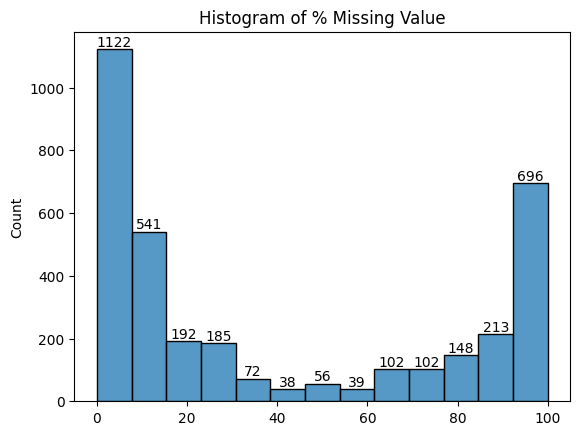

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.histplot(var_with_missing_values['num_null_values'] / (var_with_missing_values['num_null_values'] + var_with_missing_values['num_non_null_values'])*100)
ax.bar_label(ax.containers[0])

plt.title("Histogram of % Missing Value")
plt.show()

# Check Data Accuracy
Does Metadata from Source is accurate as the data ingested?

In [12]:
drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
metadata_path = 'Dataset/Variable List.xlsx'

metadata = pd.read_excel(os.path.join(drive_path, metadata_path))
metadata['filename'] = metadata['title'] + '.csv'
metadata['var_name'] = metadata['variable']
metadata

,name,title,doc_url,doc_url.1,variable,desc,missing_count,total_count,Pct Missing,is_used,lifestyle,filename,var_name
0,Demographics,Demographic Variables and Sample Weights,/Nchs/Nhanes/2017-2018/DEMO_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEM...,SEQN,Respondent sequence number,0,9254,0.000000,True,False,Demographic Variables and Sample Weights.csv,SEQN
1,Demographics,Demographic Variables and Sample Weights,/Nchs/Nhanes/2017-2018/DEMO_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEM...,SDDSRVYR,Data release cycle,0,9254,0.000000,False,False,Demographic Variables and Sample Weights.csv,SDDSRVYR
2,Demographics,Demographic Variables and Sample Weights,/Nchs/Nhanes/2017-2018/DEMO_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEM...,RIDSTATR,Interview/Examination status,0,9254,0.000000,False,False,Demographic Variables and Sample Weights.csv,RIDSTATR
3,Demographics,Demographic Variables and Sample Weights,/Nchs/Nhanes/2017-2018/DEMO_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEM...,RIAGENDR,Gender,0,9254,0.000000,True,False,Demographic Variables and Sample Weights.csv,RIAGENDR
4,Demographics,Demographic Variables and Sample Weights,/Nchs/Nhanes/2017-2018/DEMO_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEM...,RIDAGEYR,Age in years at screening,0,9254,0.000000,True,False,Demographic Variables and Sample Weights.csv,RIDAGEYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,Questionnaire,Weight History,/Nchs/Nhanes/2017-2018/WHQ_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/WHQ...,WHQ200,Age when you had wt loss surgery,6087,6161,0.987989,False,False,Weight History.csv,WHQ200
4267,Questionnaire,Weight History - Youth,/Nchs/Nhanes/2017-2018/WHQMEC_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/WHQ...,SEQN,Respondent sequence number,56,1304,0.042945,False,False,Weight History - Youth.csv,SEQN
4268,Questionnaire,Weight History - Youth,/Nchs/Nhanes/2017-2018/WHQMEC_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/WHQ...,WHQ030M,How do you consider your weight,56,1304,0.042945,False,False,Weight History - Youth.csv,WHQ030M
4269,Questionnaire,Weight History - Youth,/Nchs/Nhanes/2017-2018/WHQMEC_J.htm,https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/WHQ...,WHQ500,Trying to do about weight,56,1304,0.042945,False,False,Weight History - Youth.csv,WHQ500


In [13]:
nhanes_vars = summary_df.loc[[True if var != "SEQN" else False for var in summary_df['var_name'].tolist()], :]

nhanes_metadata = metadata.loc[[True if var != "SEQN" else False for var in metadata['variable'].tolist()], :]
# nhanes_metadata

merged_data = pd.merge(nhanes_vars, nhanes_metadata[['filename', 'var_name', 'missing_count', 'total_count', 'desc']], on=['filename', 'var_name'], suffixes=['_actual', '_from_source'])
merged_data

,dataset,filename,var_name,data_type,num_null_values,num_non_null_values,num_duplicates_values,num_unique_values,mean,median,standard_deviation,missing_count,total_count,desc
0,Demographics,Demographic Variables and Sample Weights.csv,SDDSRVYR,float64,0,9254,NaN,1,10.000000,10.0,0.000000,0,9254,Data release cycle
1,Demographics,Demographic Variables and Sample Weights.csv,RIDSTATR,float64,0,9254,NaN,2,1.940566,2.0,0.236448,0,9254,Interview/Examination status
2,Demographics,Demographic Variables and Sample Weights.csv,RIAGENDR,float64,0,9254,NaN,2,1.507564,2.0,0.499970,0,9254,Gender
3,Demographics,Demographic Variables and Sample Weights.csv,RIDAGEYR,float64,0,9254,NaN,81,34.334234,31.0,25.500280,0,9254,Age in years at screening
4,Demographics,Demographic Variables and Sample Weights.csv,RIDAGEMN,float64,8657,597,NaN,25,10.437186,10.0,7.092970,8657,9254,Age in months at screening - 0 to 24 mos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,Questionnaire,Weight History.csv,WHQ190,float64,0,6161,NaN,2,1.987989,2.0,0.108944,0,6161,Have you ever had wt loss surgery?
2553,Questionnaire,Weight History.csv,WHQ200,float64,6087,74,NaN,36,1395.067568,45.0,11619.500619,6087,6161,Age when you had wt loss surgery
2554,Questionnaire,Weight History - Youth.csv,WHQ030M,float64,56,1248,NaN,5,2.588942,3.0,0.895559,56,1304,How do you consider your weight
2555,Questionnaire,Weight History - Youth.csv,WHQ500,float64,56,1248,NaN,5,2.459936,3.0,1.261355,56,1304,Trying to do about weight


In [14]:
(merged_data['missing_count'] == merged_data['num_null_values']).sum() / merged_data.shape[0] * 100

98.86585842784513

In [17]:
(merged_data['num_non_null_values'] + merged_data['num_null_values']  == merged_data['total_count']).sum() / merged_data.shape[0] * 100

99.53070003910834

In [29]:
inaccurate_data = merged_data.loc[merged_data['missing_count'] != merged_data['num_null_values'], ['filename', 'var_name', 'desc', 'missing_count', 'num_null_values']].rename(columns={'filename': "File Name", 'var_name': "Variable", 'desc': "Description", 'num_null_values': 'Actual Missing Count', 'missing_count': 'Metadata Missing Count'})

inaccurate_data['Difference'] = inaccurate_data['Metadata Missing Count'] - inaccurate_data['Actual Missing Count']
# inaccurate_data['% Relative Difference'] = np.abs(inaccurate_data['Metadata Missing Count'] - inaccurate_data['Actual Missing Count']) / inaccurate_data['Metadata Missing Count'] * 100

inaccurate_data.loc[inaccurate_data['File Name'] != "Disability.csv", :].reset_index(drop=True).head(6)

,File Name,Variable,Description,Metadata Missing Count,Actual Missing Count,Difference
0,Dietary Supplement Database - Blend Informatio...,DSDBCID,BLEND COMPONENT ID - OLD VERSION,7636,0,7636
1,Dietary Supplement Database - Ingredient Infor...,DSDINGID,INGREDIENT ID NUMBER - OLD VERSION,26538,0,26538
2,Dietary Supplement Database - Product Informat...,DSDSUPID,SUPPLEMENT ID NUMBER - OLD VERSION,3080,0,3080
3,Audiometry.csv,AUATYMTR,"Tympanogram Type, Right Ear",218,0,218
4,Audiometry.csv,AUATYMTL,"Tympanogram Type, Left Ear",218,0,218
5,Prescription Medications.csv,RXDDRUG,Generic drug name,5209,0,5209


In [23]:
inaccurate_data = merged_data.loc[(merged_data['num_non_null_values'] + merged_data['num_null_values'] != merged_data['total_count']), ['filename', 'var_name', 'desc', 'total_count', 'num_null_values', 'num_non_null_values']].rename(columns={'filename': "File Name", 'var_name': "Variable", 'desc': "Description", 'total_count': 'Source Total Count'})
inaccurate_data['Actual Total Count'] = inaccurate_data['num_null_values'] + inaccurate_data['num_non_null_values']
inaccurate_data = inaccurate_data.drop(columns=['num_null_values', 'num_non_null_values'])

inaccurate_data['Difference'] = inaccurate_data['Source Total Count'] - inaccurate_data['Actual Total Count']

inaccurate_data.reset_index(drop=True)

,File Name,Variable,Description,Source Total Count,Actual Total Count,Difference
0,Disability.csv,DLQ010,Have serious difficulty hearing?,8898,8897,1
1,Disability.csv,DLQ020,Have serious difficulty seeing?,8898,8897,1
2,Disability.csv,DLQ040,Have serious difficulty concentrating?,8898,8897,1
3,Disability.csv,DLQ050,Have serious difficulty walking?,8898,8897,1
4,Disability.csv,DLQ060,Have difficulty dressing or bathing?,8898,8897,1
5,Disability.csv,DLQ080,Have difficulty doing errands alone?,8898,8897,1
6,Disability.csv,DLQ100,How often do you feel worried or anxious,8898,8897,1
7,Disability.csv,DLQ110,Take medication for these feelings?,8898,8897,1
8,Disability.csv,DLQ130,How worried or anxious were you?,8898,8897,1
9,Disability.csv,DLQ140,How often do you feel depressed?,8898,8897,1


In [5]:
audiometry = pd.read_csv(os.path.join(drive_path, data_path + "/" + 'Examination/Audiometry.csv'))

audiometry['AUATYMTR'].value_counts()

AUATYMTR
b'Type A'     2487
b''            218
b'Type AS'     120
b'88888'       116
b'Type C'       81
b'99999'        59
b'Type B'       29
b'Type AD'      21
Name: count, dtype: int64